# 実験001: ベースラインモデル

Playground Series S5E4: ポッドキャスト聴取時間予測

## 1. ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import lightgbm as lgb

warnings.filterwarnings('ignore')

# 表示設定
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# スタイル設定
sns.set_style('whitegrid')
plt.style.use('default')

# シード値の設定
np.random.seed(42)

## 2. データの読み込み

In [2]:
# データパスの設定
data_dir = Path('../../data')

# データの読み込み
train_df = pd.read_csv(data_dir / 'train.csv')
test_df = pd.read_csv(data_dir / 'test.csv')
sample_submission = pd.read_csv(data_dir / 'sample_submission.csv')

print(f"訓練データ: {train_df.shape}")
print(f"テストデータ: {test_df.shape}")
print(f"提出サンプル: {sample_submission.shape}")

# 目標変数の確認
target_col = 'Listening_Time_minutes'
print(f"\n目標変数: {target_col}")
print(f"目標変数の統計: {train_df[target_col].describe()}")

訓練データ: (750000, 12)
テストデータ: (250000, 11)
提出サンプル: (250000, 2)

目標変数: Listening_Time_minutes
目標変数の統計: count    750000.000000
mean         45.437406
std          27.138306
min           0.000000
25%          23.178350
50%          43.379460
75%          64.811580
max         119.970000
Name: Listening_Time_minutes, dtype: float64


## 3. 特徴量エンジニアリング

In [3]:
def preprocess_data(df, is_train=True, target_col='Listening_Time_minutes'):
    """
    データの前処理を行う関数
    """
    # データのコピー
    df_processed = df.copy()
    
    # IDカラムを保存
    if 'id' in df_processed.columns:
        ids = df_processed['id']
        df_processed = df_processed.drop('id', axis=1)
    
    # 目標変数の分離（訓練データの場合）
    if is_train and target_col in df_processed.columns:
        y = df_processed[target_col]
        df_processed = df_processed.drop(target_col, axis=1)
    else:
        y = None
    
    # カテゴリカル変数と数値変数を分離
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    print(f"カテゴリカル変数: {len(categorical_cols)}個")
    print(f"数値変数: {len(numerical_cols)}個")
    
    # 数値変数の欠損値補完
    for col in numerical_cols:
        if df_processed[col].isnull().sum() > 0:
            median_value = df_processed[col].median()
            df_processed[col] = df_processed[col].fillna(median_value)
            print(f"{col}の欠損値を中央値{median_value:.2f}で補完")
    
    # 新規特徴量の作成
    # 1. 広告密度（広告数/エピソード長）
    df_processed['Ad_Density'] = df_processed['Number_of_Ads'] / (df_processed['Episode_Length_minutes'] + 1e-8)
    
    # 2. ホストとゲストの人気度の差
    df_processed['Host_Guest_Popularity_Diff'] = (df_processed['Host_Popularity_percentage'] - 
                                                   df_processed['Guest_Popularity_percentage'].fillna(0))
    
    # 3. ゲストの存在フラグ
    df_processed['Has_Guest'] = (~df_processed['Guest_Popularity_percentage'].isnull()).astype(int)
    
    # Guest_Popularity_percentageの欠損値を0で補完
    df_processed['Guest_Popularity_percentage'] = df_processed['Guest_Popularity_percentage'].fillna(0)
    
    # カテゴリカル変数のエンコーディング
    le_dict = {}
    for col in categorical_cols:
        le = LabelEncoder()
        # 欠損値がある場合は'Missing'で埋める
        df_processed[col] = df_processed[col].fillna('Missing')
        df_processed[col] = le.fit_transform(df_processed[col])
        le_dict[col] = le
        print(f"{col}をラベルエンコーディング: {len(le.classes_)}カテゴリ")
    
    return df_processed, y, ids if 'ids' in locals() else None, le_dict

# データの前処理実行
print("=== 訓練データの前処理 ===")
X_train_processed, y_train, train_ids, le_dict_train = preprocess_data(train_df, is_train=True)

print("\n=== テストデータの前処理 ===")
X_test_processed, _, test_ids, _ = preprocess_data(test_df, is_train=False)

print(f"\n処理後の訓練データ形状: {X_train_processed.shape}")
print(f"処理後のテストデータ形状: {X_test_processed.shape}")
print(f"特徴量一覧: {X_train_processed.columns.tolist()}")

=== 訓練データの前処理 ===
カテゴリカル変数: 6個
数値変数: 4個
Episode_Length_minutesの欠損値を中央値63.84で補完
Guest_Popularity_percentageの欠損値を中央値53.58で補完
Number_of_Adsの欠損値を中央値1.00で補完
Podcast_Nameをラベルエンコーディング: 48カテゴリ


Episode_Titleをラベルエンコーディング: 100カテゴリ


Genreをラベルエンコーディング: 10カテゴリ
Publication_Dayをラベルエンコーディング: 7カテゴリ
Publication_Timeをラベルエンコーディング: 4カテゴリ


Episode_Sentimentをラベルエンコーディング: 3カテゴリ

=== テストデータの前処理 ===
カテゴリカル変数: 6個
数値変数: 4個
Episode_Length_minutesの欠損値を中央値63.97で補完
Guest_Popularity_percentageの欠損値を中央値53.36で補完
Podcast_Nameをラベルエンコーディング: 48カテゴリ


Episode_Titleをラベルエンコーディング: 100カテゴリ
Genreをラベルエンコーディング: 10カテゴリ
Publication_Dayをラベルエンコーディング: 7カテゴリ
Publication_Timeをラベルエンコーディング: 4カテゴリ
Episode_Sentimentをラベルエンコーディング: 3カテゴリ

処理後の訓練データ形状: (750000, 13)
処理後のテストデータ形状: (250000, 13)
特徴量一覧: ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes', 'Genre', 'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment', 'Ad_Density', 'Host_Guest_Popularity_Diff', 'Has_Guest']


## 4. モデルの訓練と検証

In [4]:
# 訓練・検証データの分割
X_train, X_val, y_train_split, y_val = train_test_split(
    X_train_processed, y_train, 
    test_size=0.2, 
    random_state=42
)

print(f"訓練データ: {X_train.shape}")
print(f"検証データ: {X_val.shape}")

訓練データ: (600000, 13)
検証データ: (150000, 13)


In [5]:
# LightGBMモデルの訓練
print("=== LightGBMモデルの訓練 ===")

# パラメータ設定
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

# データセットの作成
train_data = lgb.Dataset(X_train, label=y_train_split)
val_data = lgb.Dataset(X_val, label=y_val)

# モデル訓練
lgb_model = lgb.train(
    lgb_params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)]
)

=== LightGBMモデルの訓練 ===


Training until validation scores don't improve for 100 rounds


[100]	train's rmse: 13.1202	valid's rmse: 13.1065


[200]	train's rmse: 13.0334	valid's rmse: 13.066


[300]	train's rmse: 12.9714	valid's rmse: 13.0454


[400]	train's rmse: 12.9199	valid's rmse: 13.0295


[500]	train's rmse: 12.871	valid's rmse: 13.0159


[600]	train's rmse: 12.8254	valid's rmse: 13.0055


[700]	train's rmse: 12.7866	valid's rmse: 12.9969


[800]	train's rmse: 12.746	valid's rmse: 12.9876


[900]	train's rmse: 12.7059	valid's rmse: 12.9807


[1000]	train's rmse: 12.6652	valid's rmse: 12.9741
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 12.6652	valid's rmse: 12.9741


## 5. モデル評価

In [6]:
# 予測
y_train_pred = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
y_val_pred = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

# 評価指標の計算
def calculate_metrics(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n=== {dataset_name}の評価結果 ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    return rmse, mae, r2

# 訓練データでの評価
train_rmse, train_mae, train_r2 = calculate_metrics(y_train_split, y_train_pred, "訓練データ")

# 検証データでの評価
val_rmse, val_mae, val_r2 = calculate_metrics(y_val, y_val_pred, "検証データ")


=== 訓練データの評価結果 ===
RMSE: 12.6652
MAE: 9.2910
R²: 0.7822

=== 検証データの評価結果 ===
RMSE: 12.9741
MAE: 9.4493
R²: 0.7712


## 6. Cross Validation

In [7]:
# 5-fold Cross Validation
print("=== 5-Fold Cross Validation ===")

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_processed)):
    print(f"\nFold {fold + 1}/5")
    
    # データ分割
    X_fold_train, X_fold_val = X_train_processed.iloc[train_idx], X_train_processed.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # データセット作成
    fold_train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
    fold_val_data = lgb.Dataset(X_fold_val, label=y_fold_val)
    
    # モデル訓練
    fold_model = lgb.train(
        lgb_params,
        fold_train_data,
        valid_sets=[fold_train_data, fold_val_data],
        valid_names=['train', 'valid'],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=0)]
    )
    
    # 予測と評価
    fold_pred = fold_model.predict(X_fold_val, num_iteration=fold_model.best_iteration)
    fold_rmse = np.sqrt(mean_squared_error(y_fold_val, fold_pred))
    cv_scores.append(fold_rmse)
    
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

print(f"\n=== Cross Validation結果 ===")
print(f"平均RMSE: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"各FoldのRMSE: {[f'{score:.4f}' for score in cv_scores]}")

=== 5-Fold Cross Validation ===

Fold 1/5
Training until validation scores don't improve for 100 rounds


Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 12.6755	valid's rmse: 12.9762


Fold 1 RMSE: 12.9762

Fold 2/5
Training until validation scores don't improve for 100 rounds


Did not meet early stopping. Best iteration is:
[997]	train's rmse: 12.6601	valid's rmse: 13.0254


Fold 2 RMSE: 13.0254

Fold 3/5
Training until validation scores don't improve for 100 rounds


Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 12.6705	valid's rmse: 13.0208


Fold 3 RMSE: 13.0208

Fold 4/5
Training until validation scores don't improve for 100 rounds


Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 12.6744	valid's rmse: 13.0126


Fold 4 RMSE: 13.0126

Fold 5/5
Training until validation scores don't improve for 100 rounds


Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 12.68	valid's rmse: 12.9766


Fold 5 RMSE: 12.9766

=== Cross Validation結果 ===
平均RMSE: 13.0023 ± 0.0216
各FoldのRMSE: ['12.9762', '13.0254', '13.0208', '13.0126', '12.9766']


## 7. 特徴量重要度の確認

=== 特徴量重要度 Top 10 ===
                        feature    importance
2        Episode_Length_minutes  2.569072e+09
10                   Ad_Density  1.598286e+08
8                 Number_of_Ads  4.621880e+07
4    Host_Popularity_percentage  2.216789e+07
7   Guest_Popularity_percentage  1.193137e+07
1                 Episode_Title  1.108942e+07
11   Host_Guest_Popularity_Diff  7.786250e+06
0                  Podcast_Name  6.837561e+06
5               Publication_Day  4.543570e+06
3                         Genre  4.136674e+06


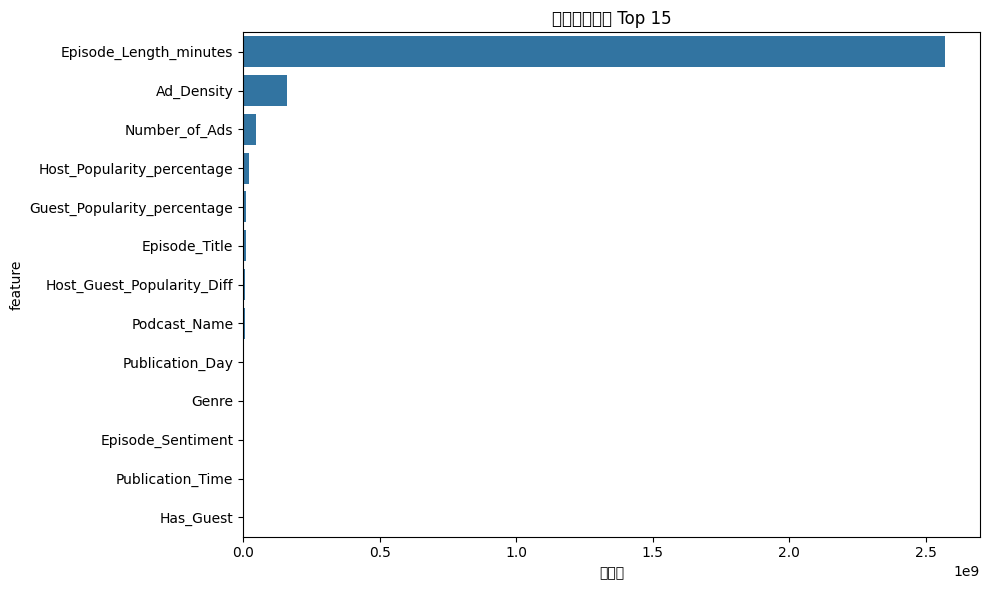

In [8]:
# 特徴量重要度の可視化
feature_importance = lgb_model.feature_importance(importance_type='gain')
feature_names = X_train_processed.columns

# 重要度をDataFrameにまとめる
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("=== 特徴量重要度 Top 10 ===")
print(importance_df.head(10))

# 可視化
plt.figure(figsize=(10, 6))
top_features = importance_df.head(15)
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('特徴量重要度 Top 15')
plt.xlabel('重要度')
plt.tight_layout()
plt.show()

## 8. 予測と提出ファイルの作成

In [9]:
# テストデータでの予測
test_predictions = lgb_model.predict(X_test_processed, num_iteration=lgb_model.best_iteration)

# 提出ファイルの作成
submission_df = pd.DataFrame({
    'id': test_ids,
    target_col: test_predictions
})

print("=== 提出ファイルの統計 ===")
print(submission_df[target_col].describe())

# ファイル保存
results_dir = Path('../../results/exp001')
results_dir.mkdir(parents=True, exist_ok=True)

submission_path = results_dir / 'submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f"\n提出ファイルを保存: {submission_path}")

# サンプル提出ファイルとの形式確認
print(f"\n=== フォーマット確認 ===")
print(f"サンプル提出ファイル形状: {sample_submission.shape}")
print(f"作成した提出ファイル形状: {submission_df.shape}")
print(f"カラム名一致: {list(sample_submission.columns) == list(submission_df.columns)}")

=== 提出ファイルの統計 ===
count    250000.000000
mean         45.626512
std          23.723513
min           0.370397
25%          26.889668
50%          44.968778
75%          64.991990
max         116.194206
Name: Listening_Time_minutes, dtype: float64

提出ファイルを保存: ../../results/exp001/submission.csv

=== フォーマット確認 ===
サンプル提出ファイル形状: (250000, 2)
作成した提出ファイル形状: (250000, 2)
カラム名一致: True


## 9. 結果の保存

In [ ]:
# モデルの保存
import pickle
import json

model_path = results_dir / 'model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(lgb_model, f)
print(f"モデルを保存: {model_path}")

# 実験結果の記録（MLflow用に詳細データを追加）
experiment_results = {
    'experiment_id': 'exp001',
    'model_type': 'LightGBM',
    'model_params': lgb_params,
    
    # 特徴量情報
    'features': list(X_train_processed.columns),
    'num_features': len(X_train_processed.columns),
    'new_features': ['Ad_Density', 'Host_Guest_Popularity_Diff', 'Has_Guest'],
    
    # 評価指標
    'train_rmse': float(train_rmse),
    'train_mae': float(train_mae),
    'train_r2': float(train_r2),
    'val_rmse': float(val_rmse),
    'val_mae': float(val_mae),
    'val_r2': float(val_r2),
    
    # Cross Validation結果
    'cv_scores': [float(score) for score in cv_scores],
    'cv_rmse_mean': float(np.mean(cv_scores)),
    'cv_rmse_std': float(np.std(cv_scores)),
    
    # 特徴量重要度
    'feature_importance': {
        row['feature']: int(row['importance']) 
        for _, row in importance_df.iterrows()
    },
    
    # Kaggleスコア（手動で設定）
    'public_score': 13.13295,
    'private_score': 13.02087,
    
    # データ情報
    'train_size': len(X_train_processed),
    'test_size': len(X_test_processed),
    'target_variable': target_col,
    
    # 実験設定
    'cv_folds': 5,
    'validation_split': 0.2,
    'random_state': 42,
    'preprocessing': {
        'missing_value_strategy': 'median_imputation',
        'categorical_encoding': 'label_encoding',
        'feature_engineering': 'label_encoding,missing_value_imputation,new_features'
    }
}

# 実験結果をJSONファイルに保存
results_json_path = results_dir / 'experiment_results.json'
with open(results_json_path, 'w', encoding='utf-8') as f:
    json.dump(experiment_results, f, indent=2, ensure_ascii=False)
print(f"実験結果を保存: {results_json_path}")

print("\n=== 実験結果サマリー ===")
print(f"モデル: {experiment_results['model_type']}")
print(f"特徴量数: {len(experiment_results['features'])}個")
print(f"検証RMSE: {experiment_results['val_rmse']:.4f}")
print(f"CV平均RMSE: {experiment_results['cv_rmse_mean']:.4f} ± {experiment_results['cv_rmse_std']:.4f}")
print(f"\n重要な特徴量トップ5:")
for i, (feature, importance) in enumerate(list(experiment_results['feature_importance'].items())[:5]):
    print(f"  {i+1}. {feature}: {importance:,}")